# Kalman Filter

Author: [Minh Kieu](https://github.com/leminhkieu) (with some extra text by [Nick Malleson](https://github.com/nickmalleson/)).

This notebook explains classical Kalman Filter (KF) and give a simple examples. The Kalman Filter is a method that can be used to estimate a new system state from previous states and new, noisy, information. 

The code is adapted from:

 - https://arxiv.org/ftp/arxiv/papers/1204/1204.0375.pdf
 - https://stackoverflow.com/questions/13901997/kalman-2d-filter-in-python
 
As this is part of a project about agent-based modelling, its applicability to these kinds of models will be discussed explicitly.

In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Example: location and velocity of a moving object

This example simulates the hypothetical movement of an object on a flat plan. The system is represented by a **state matrix**, $X$, which has a dimension $N$. In our case $N=3$ because we have 2D location and velocity ($x$, $y$, $velocity$).

We can estimate $X$ by taking observations. However, usually we do not observe all of the variables (in this case we only know the location ($x$, $y$) but not the velocity). Therefore the **measurement matrix**, $Z$, which we use to estimate $X$, has a dimension smaller or equal to $N$: $dim(Z) \leq N$.

These matrices will be elaborated on below.

## Main functions: _predict_ and _update_

### Predict

A Kalman Filter has two main functions: _predict_ and _update_.

The purpose of the **predict** step is to estimate the current state of the system at time $k$, based on the previous measurements. In the context of agent-based modelling, predict means iterating the model for a number of time steps (i.e. running the model). Mathematically, the update step looks like this:

$$
X_{k+1} = f(X_k) + W_k
$$

We try to estimate the new state of the system at the next time step ($X_{k+1}$) by applying a function to the old state ($f(X_k)$) and adding some noise ($W_k$). With an ABM, $f(X_k)$ means 'run the model forward'. However, to make the Kalman Filter work, we assume here that $f$ is linear (this probably isn't a safe assumption for an ABM), so therefore we can do:

$$
X_{k+1} = F*X_k + W_k
$$

This means that we can simply multiply our current state $X_k$ by another matrix, $F$, to get the new state. $F$ is called the _state transition matrix_. So what does $F$ look like?  

With simple systems, it is easy to define $F$. For example, with our example of position ($x$ and $y$) and velocity ($v_x$ and $v_y$), the state transition matrix would look like:

$$
X = 
 \begin{bmatrix}
   x \\
   y \\
   v_x \\
   v_y
 \end{bmatrix}
$$
 
(Big '$X$' means state transition matrix and little '$x$' means the x coordinate; sorry, I know that's confusing!).

Then if we assume that the object is not accelarating, and we know it's current speed, $\Delta v$, $F$ looks like:

$$
F = 
 \begin{bmatrix}
   1 & 0 & \Delta v_x & 0 \\ 
   0 & 1 & 0 & \Delta v_y \\ 
   0 & 0 &  1 & 0 \\ 
   0 & 0 & 0 & 1 \\ 
 \end{bmatrix}
$$

When we do $F * X$, the velocity of the object doesn't change, but it's $x$ and $y$ coordinates will change by $\Delta v_x$ and $\Delta v_y$ (i.e. the amount it has moved in the $x$ and $y$ planes).

We also need to calculate the _predicted covariance_ in the predict step. This comes from the initial uncertainty covariance matrix, whose purpose is to quantify the covariance between the model parameters. Assuming there is no covariance between the parameters ($x$, $y$, $v_x$, $v_y$) it will look like: 

$$
 P' = 
 \begin{bmatrix}
   1 & 0 & 0 & 0 \\ 
   0 & 1 & 0 & 0 \\ 
   0 & 0 &  1 & 0 \\ 
   0 & 0 & 0 & 1 \\ 
 \end{bmatrix}
$$

Then the _predicted covariance_ can be calculated as:

$$
 P' = F P F^T + Q
$$


### Update

The **update** step _combines new measurements with current system state_. In this manner, the modelled state of the system after the update step should be more similar to the real system state.

To begin with, we need some measurements. Call these $z$. We can then use these measurements to estimate the difference between the actual value and the measured value, $y$, by using the state transition matrix:

$$
 y = z - H . x'
$$

where $y$ is the difference between the real and measured value, $z$ is the measurement, $H$ is the state transition matrix (the same as $F$ in the previous step). Note that in this application, $F$ and $H$ are basically the same, but in a real application they could be different. This can occur when we _meausure_ one thing, but _model_ another. For example, here we both model and measure the object's location and velocity. But it is possible that we would measure something else, like the 

$F$ is the transition function (i.e. our model) but $H$ is a function that translates from measurements to 

Then we can do:

$$
 S = H P' H^T + R \\
 K = P' H^T S^{-1}
$$

where
 - $R$ is the measurement noise (the measuring device should state what this is);
 - $K$ is the Kalman Gain matrix (discussed below)
 - $S$ is the total error in the system (error in the prediction plus error in the measurement)

The Kalman Gain parameter, $K$, determines how much weight to give to the current prediction v.s. the new measurement. The amount of uncertainty around the measurements determines how much infuence they should have on the prediction (i.e. less uncertainty -> more confidence in the measured values -> a greater impact on the prediction). To estimate $K$ we need to quantify the error in the model prediction and the error in the new measurements. Importantly for agent-based modelling, _how do we calculate the uncertainty of our model?_.

Finally update $X$ (the system state) ad $P$ (the covariance) according to the Kalman Gain.  :

$$
 x = x' + K.y \\
 P = (I - K H)P'
$$



## The code

The following code implements the _predict_ and _update_ functions. The symbols used are:

For **predict**:

X,P,A,Q,B,U

 - `X`: initial state matrix before application of the _predict_ and _update_ functions (i.e. the state at time $k-1$). This is a list of current values for each of the state variables.
 - `P`: initial uncertaity coveriance matrix (at time $k-1$), representing the covariance of the uncertainty of the variables. This is a matrix with shape $N * N$.
 - `A`: next state function: $X' = F*x$ (an $n * n$ matrix)
 - `Q`: motion noise (same shape as $P$)
 - `B`: The input effect matrix (n x 1)
 - `U`: ??

For **udpate**:
 - `X`: the state matrix after the `predict` step
 - `P`: the _predicted_ covariance matrix (i.e. the covariance after the `predict` step). 
 - `Y`: the difference between the measurements and the current state estimate (_correct?_)
 - `H`: measurement function: position z=H*x
 - `R`: measurement noise (same shape as H)

_What are these?_:

 - `measurement`: an observation of the system state (same shape as H*x)
 - `motion`: external motion added to state vector x
 
 

In [5]:
"""
First, let's define the predict and update algorithms for the Kalman filter. 
If you need to read the equations, refer to https://en.wikipedia.org/wiki/Kalman_filter

   Parameters:
        X: initial state
        P: initial uncertainty coveriance matrix
        measurement: observed postion (same shape as H*x)
        R: measurement noise (same shape as H)
        motion: external motion added to state vector x
        Q: motion noise (same shape as P)
        A: next state function: x_prime = F*x (n x n matrix)
        B: The input effect matrix (n x 1)
        H: measurement function: position z=H*x
        
        Return: the updated and predicted new values for (x,P)
    """
def kf_predict(X,P,A,Q,B,U):
    X = np.dot(A,X) + np.dot(B,U) #predict the state (a piori)
    P = np.dot(A, np.dot(P,A.T)) +Q  #estimate the covariance matrix (a piori)
    return(X,P)
    
def kf_update(X,P,Y,H,R):
    V = Y.T-np.dot(H,X) #innovation or measurement residual
    S = np.dot(H, np.dot(P,H.T))+R #measurement prediction covariance
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))  #Kalman gain
    X = X + np.dot(K,V)  #now estimate the mean (a posteriori)
    P = P - np.dot(K,np.dot(S,K.T)) #estimate the covariance matrix (a posteriori)
    return(X,P,K,V,S,H)

In [14]:
"""
Now example: Tracking of mobile in wireless network
Initialisation of state matrices
Please note that for KF the results are very sensitive to parameters, I would suggest to play abit with the parameters
"""

X = np.array([[0.0],[0.0],[0.1],[0.1]]) #first two for location (0,0), later two for velocity (0.1,0.1) at a 2-D lattice x,y
#P = np.diag((0.01,0.01,0.01,0.01))
P = np.matrix(np.eye(4))*1000 # initial uncertainty
dt = 0.1 #this will shape the state transition model A
A = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]]) #transition matrix (x_t-1 -> x_t)
H = np.array([[1,0,0,0],[0,1,0,0]]) #measurement matrix   y = H*x   (x, the true state, cannot be observed)
Q = np.eye(X.shape[0])
B = np.eye(X.shape[0])
U = np.zeros((X.shape[0],1))
#Measurement matrices
N=20
true_x = np.linspace(0.0, 10.0, N)
true_y = true_x**2
observed_x = true_x + 0.1*np.random.random(N)*true_x
observed_y = true_y + 0.1*np.random.random(N)*true_y
Y= np.vstack((observed_x,observed_y)).T
result = []

R =0.1**2

 - Tranlating the model into matrix A can be difficult (e.g. non-trivial to do with an ABM). 
   - (An emulator could be used to translate the model into A)

 
 

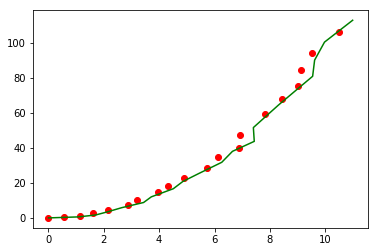

In [15]:
#now the main KF loop
for i in range(0,N):
    
    #print(X)
    (X,P,K,V,S,H)=kf_update(X,P,np.array([Y[i]]),H,R)
    (X,P)= kf_predict(X,P,A,Q,B,U)
    #print(K)
    result.append((X[:2]).tolist())
#plotting
kalman_x, kalman_y = zip(*result)
plt.plot(observed_x, observed_y, 'ro')
plt.plot(kalman_x, kalman_y, 'g-')
#plt.show()